# Brain Tumor Detection

In [3]:
# Import necessary libraries 
import os
import numpy as np
import cv2 
import imutils
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

2023-04-05 17:30:12.056834: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-05 17:30:12.058490: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-05 17:30:12.094375: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-05 17:30:12.094945: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 17:30:12.862417: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [5]:
# Define the path to the dataset
IMG_PATH = 'brain_tumor_dataset/'

# Create a list of all the image filenames
all_images = []
for folder in ['yes', 'no']:
    folder_path = os.path.join(IMG_PATH, folder)
    for filename in os.listdir(folder_path):
        
         all_images.append(os.path.join(folder_path, filename))

# Create a list of corresponding labels (0 for 'no', 1 for 'yes')
labels = [1 if 'Y' in filename else 0 for filename in all_images]

# Split the dataset into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(all_images, labels, test_size=0.03, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=123)

# Print the sizes of the resulting datasets
print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Train set size: 183
Validation set size: 62
Test set size: 8


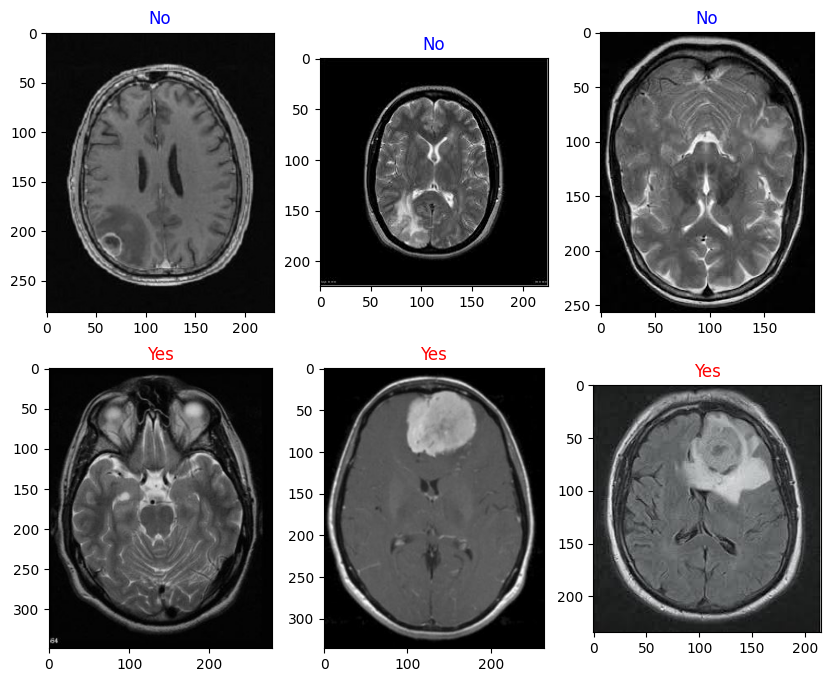

In [6]:
%matplotlib inline
IMG_PATH = 'brain_tumor_dataset/'

labels = {0: 'No', 1: 'Yes'}
colors = {0: 'blue', 1: 'red'}

fig, axs = plt.subplots(2, 3, figsize=(10, 8))
for i, label in enumerate([0, 1]):
    images = [x for x, y in zip(X_train, y_train) if y == label][:3]
    for j, image_path in enumerate(images):
        img = plt.imread(image_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(labels[label], color=colors[label])
plt.show()

In [7]:
def preprocess_images(images):
    preprocessed_images = []
    for i, img_path in enumerate(images):
        img = cv2.imread(img_path)
        img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # crop
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(
            new_img,
            dsize=(224,224))
        preprocessed_images.append(new_img)
    return np.array(preprocessed_images)

In [8]:
# Apply the preprocessing to all the data subsets 
X_train_pre = preprocess_images(X_train)
X_val_pre = preprocess_images(X_val)
X_test_pre = preprocess_images(X_test)

In [9]:
# Transform the subsets to numpy arrays 
X_train_pre_vgg = np.array([preprocess_input(image) for image in X_train_pre])
X_val_pre_vgg = np.array([preprocess_input(image) for image in X_val_pre])
X_test_pre_vgg = np.array([preprocess_input(image) for image in X_test_pre])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


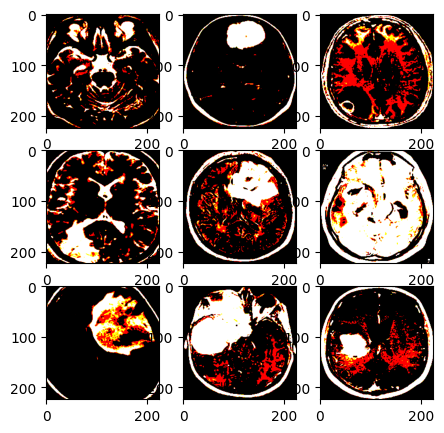

In [10]:
# plot some images from X_train_pre
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train_pre_vgg[i], cmap='gray')
plt.show()

In [12]:
# Load the pre-trained VGG19 model
base_model = VGG19(
weights='imagenet',
include_top=False,
input_shape=(224,224) + (3,)
)

# Create a new model by adding a few layers on top of the pre-trained model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Freeze the weights of the pre-trained model
model.layers[0].trainable = False

# Compile the model with appropriate loss function, optimizer and metrics
model.compile(
loss='binary_crossentropy',
optimizer=Adam(),
metrics=['accuracy']
)

# Print the summary of the model
model.summary()

# Define the training data generator with necessary data augmentation techniques
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=20,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest'
)

# Create the training data generator using the training dataset and the data generator
train_generator = train_datagen.flow(
X_train_pre_vgg,
y_train,
batch_size=32
)

# Define a callback to reduce the learning rate when the validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-5)

# Define a callback to stop the training when validation accuracy reaches 90%
class StopOnAccuracy(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.9:
            print("\nReached 90% accuracy, stopping training...")
            self.model.stop_training = True

# Define the validation data generator with appropriate data preprocessing
val_datagen = ImageDataGenerator(rescale=1./255)

# Create the validation data generator using the validation dataset and the data generator
val_generator = val_datagen.flow(X_val_pre_vgg, y_val, batch_size=18)

# Train the model using the training data generator, validation data generator and the defined callbacks
history = model.fit(
train_generator,
epochs=5,
validation_data=val_generator,
callbacks=[reduce_lr,StopOnAccuracy()]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/5


2023-04-05 17:54:55.470545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


6/6 [==============================] - ETA: 0s - loss: 0.8310 - accuracy: 0.5956

2023-04-05 17:55:41.042930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


6/6 [==============================] - 63s 11s/step - loss: 0.8310 - accuracy: 0.5956 - val_loss: 0.5980 - val_accuracy: 0.6452 - lr: 0.0010
Epoch 2/5
6/6 [==============================] - 65s 11s/step - loss: 0.6606 - accuracy: 0.6393 - val_loss: 0.5720 - val_accuracy: 0.7258 - lr: 0.0010
Epoch 3/5
6/6 [==============================] - 63s 11s/step - loss: 0.5639 - accuracy: 0.7268 - val_loss: 0.5537 - val_accuracy: 0.7581 - lr: 0.0010
Epoch 4/5
6/6 [==============================] - 61s 11s/step - loss: 0.5869 - accuracy: 0.7049 - val_loss: 0.5828 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 5/5
6/6 [==============================] - 61s 11s/step - loss: 0.5183 - accuracy: 0.7486 - val_loss: 0.5616 - val_accuracy: 0.6774 - lr: 0.0010


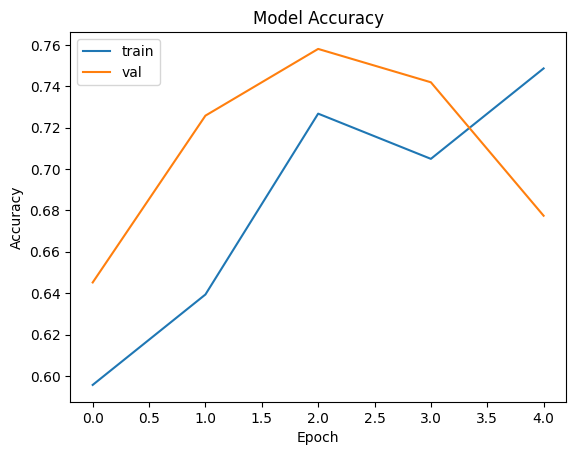

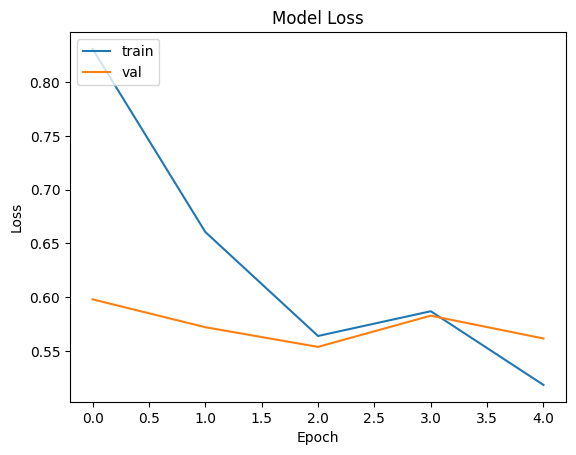

In [13]:
# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 2s 2s/step


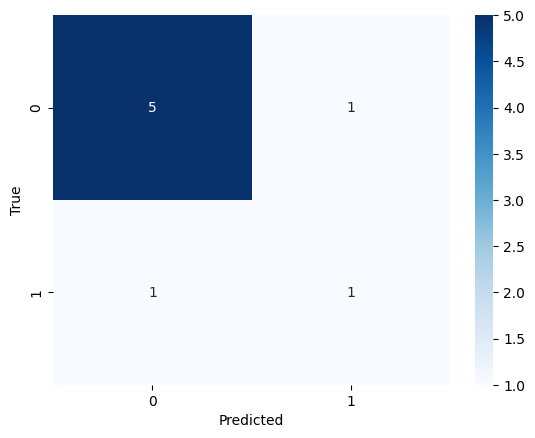

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.50      0.50      0.50         2

    accuracy                           0.75         8
   macro avg       0.67      0.67      0.67         8
weighted avg       0.75      0.75      0.75         8

Test accuracy: 0.75


In [15]:
# Make predictions on X_test_pre
y_pred = model.predict(X_test_pre)
y_pred = np.round(y_pred).astype(int)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)
print(cr)
print('Test accuracy:', test_accuracy)